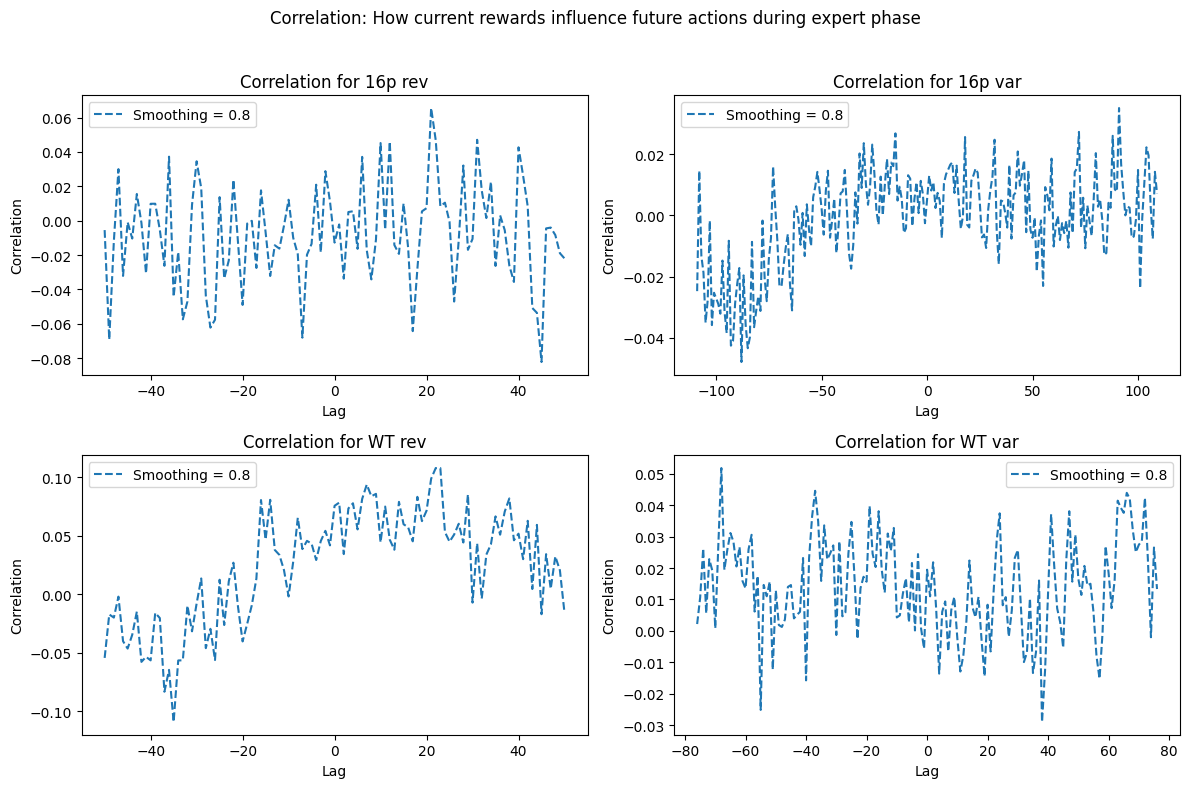

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

# Load the Excel file
df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')
mouse_per_mouse_type = int(input('How many mouse/mouse_type would you like choose numbers ranging from 1 to 5?'))
# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_16p_var = df['link_16p_var'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_WT_rev = df['link_WT_rev'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_WT_var = df['link_WT_var'].iloc[:mouse_per_mouse_type].dropna().tolist()

def find_expert_segments(expert_series, choice):
    expert_segments = []
    in_segment = False
    segment_start = None
    
    for i, value in enumerate(expert_series):
        if value and not in_segment:
            in_segment = True
            segment_start = i
        elif not value and in_segment:
            in_segment = False
            expert_segments.append([segment_start, i - 1])
            segment_start = None

    if in_segment:
        expert_segments.append([segment_start, len(expert_series) - 1])
    
    if choice == 1 and expert_segments:
        expert_segments = [expert_segments[0]]
    
    return expert_segments

def max_lag_per_mouseType(links, choice):
    dic = {}
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        expert_series = df['expert'].reset_index(drop=True)
        expert_segments = find_expert_segments(expert_series, choice)
        dic[link] = expert_segments
    return dic

choice = int(input("Enter 1 to extract only one expert phase, or 2 to allow multiple expert phases: ").strip())

Expert_16p_rev = max_lag_per_mouseType(links_16p_rev, choice)
Expert_16p_var = max_lag_per_mouseType(links_16p_var, choice)
Expert_WT_rev = max_lag_per_mouseType(links_WT_rev, choice)
Expert_WT_var = max_lag_per_mouseType(links_WT_var, choice)

def SAR_Generator(mouse_type_links, choice):
    Expert_mouse_type = max_lag_per_mouseType(mouse_type_links, choice)
    sar_dict = {link: {'states': [], 'actions': [], 'rewards': []} for link in mouse_type_links}

    for link in mouse_type_links:
        start_link, end_link = Expert_mouse_type[link][0]
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        
        S = df['tone_freq'].iloc[start_link:end_link+1].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
        A = df['response'].iloc[start_link:end_link+1].reset_index(drop=True)
        R = df['rew_t'].iloc[start_link:end_link+1].reset_index(drop=True)
        
        sar_dict[link]['states'].extend(S)
        sar_dict[link]['actions'].extend(A)
        sar_dict[link]['rewards'].extend(R)

    return sar_dict

def cross_correlation_manual(x, y, lag_var, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []
    
    for lag in range(-mx_lag, mx_lag + 1):
        c = 0
        if lag_var == 'x':
            if lag < 0:
                segment_x = x[:len(x) + lag]
                segment_y = y[-lag:]
            else:
                segment_x = x[lag:]
                segment_y = y[:len(x) - lag]
        else:
            if lag < 0:
                segment_x = x[-lag:]
                segment_y = y[:len(x) + lag]
            else:
                segment_x = x[:len(x) - lag]
                segment_y = y[lag:]
        
        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        
        if std_x != 0 and std_y != 0:
            for t in range(len(segment_x)):
                c += (segment_x[t] - mean_x) * (segment_y[t] - mean_y)
            c_lag.append(c / (std_x * std_y * (len(segment_x)-abs(lag))))
        else:
            c_lag.append(0)
    
    return c_lag

def AR_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_AR = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        rewards = dic_mouse_type[link]['rewards']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L' and rewards[i] == 1:
                Y_i = 2
            elif actions[i] == 'L' and rewards[i] == 0:
                Y_i = 1
            elif actions[i] == 'R' and rewards[i] == 0:
                Y_i = -1
            elif actions[i] == 'R' and rewards[i] == 1:
                Y_i = -2
            elif actions[i] == 'N':
                Y_i = 0
            Y.append(Y_i)
        DIC_AR[link].extend(Y)
    return DIC_AR

def S_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_S = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        X = []
        for i in range(len(states)):
            if states[i] == '6kHz':
                X_i = 1
            elif states[i] == '10kHz':
                X_i = 0
            X.append(X_i)
        DIC_S[link].extend(X)
    return DIC_S

def SA_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_SA = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        actions = dic_mouse_type[link]['actions']
        X = []
        for i in range(len(states)):
            if (states[i] == '6kHz' and actions[i] == 'L') or (states[i] == '10kHz' and actions[i] == 'R'):
                X_i = 1
            elif (states[i] == '6kHz' and actions[i] == 'R') or (states[i] == '10kHz' and actions[i] == 'L'):
                X_i = -1
            else:
                X_i = 0
            X.append(X_i)
        DIC_SA[link].extend(X)
    return DIC_SA

def A_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_A = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L':
                Y_i = 1
            elif actions[i] == 'R':
                Y_i = -1
            else:
                Y_i = 0
            Y.append(Y_i)
        DIC_A[link].extend(Y)
    return DIC_A

def R_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_R = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        X = []
        for i in range(len(rewards)):
            if rewards[i] == 1:
                X_i = 1
            else:
                X_i = 0
            X.append(X_i)
        DIC_R[link].extend(X)
    return DIC_R

def min_expert_length(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    lengths = []
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        lengths.append(len(rewards))
    max_lag = int(0.2 * min(lengths))
    return max_lag

def avg_correlate(mouse_type_links, choice):
    #correlator : A(t+tau)R(t)
    max_lag = min_expert_length(mouse_type_links, choice)
    total_corr = np.array(np.zeros(2*max_lag+1))
    num_links = len(mouse_type_links)
    #lag_var = input('What do you want your lag variable to be (R_seq/SA_seq)? '
    corrs=[]
    for link in mouse_type_links:
        DIC_R = R_mapping(mouse_type_links, choice)
        DIC_A = A_mapping(mouse_type_links, choice)
        R_seq = DIC_R[link]
        A_seq= DIC_A[link]
        
        cross_corr = cross_correlation_manual(R_seq, A_seq, A_seq, max_lag)
        total_corr += cross_corr
    lags = list(range(-max_lag, max_lag + 1))
    return total_corr / num_links, lags

def exponential_smoothing(series, alpha):
    return series.ewm(alpha=alpha).mean()

# Plotting
y_16p_rev, x_16p_rev = avg_correlate(links_16p_rev, choice)
y_16p_var, x_16p_var = avg_correlate(links_16p_var, choice)
y_WT_rev, x_WT_rev = avg_correlate(links_WT_rev, choice)
y_WT_var, x_WT_var = avg_correlate(links_WT_var, choice)

# Apply exponential smoothing
alpha = float(input('What smoothing value would you like?'))  # Smoothing factor, can be adjusted
y_16p_rev_smoothed = exponential_smoothing(pd.Series(y_16p_rev), alpha).values
y_16p_var_smoothed = exponential_smoothing(pd.Series(y_16p_var), alpha).values
y_WT_rev_smoothed = exponential_smoothing(pd.Series(y_WT_rev), alpha).values
y_WT_var_smoothed = exponential_smoothing(pd.Series(y_WT_var), alpha).values


# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
#plt.plot(x_16p_rev, y_16p_rev, label='Original')
plt.plot(x_16p_rev, y_16p_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 2)
#plt.plot(x_16p_var, y_16p_var, label='Original')
plt.plot(x_16p_var, y_16p_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 3)
#plt.plot(x_WT_rev, y_WT_rev, label='Original')
plt.plot(x_WT_rev, y_WT_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 4)
#plt.plot(x_WT_var, y_WT_var, label='Original')
plt.plot(x_WT_var, y_WT_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

# Add a single title for all plots
plt.suptitle('Correlation: How current rewards influence future actions during expert phase')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

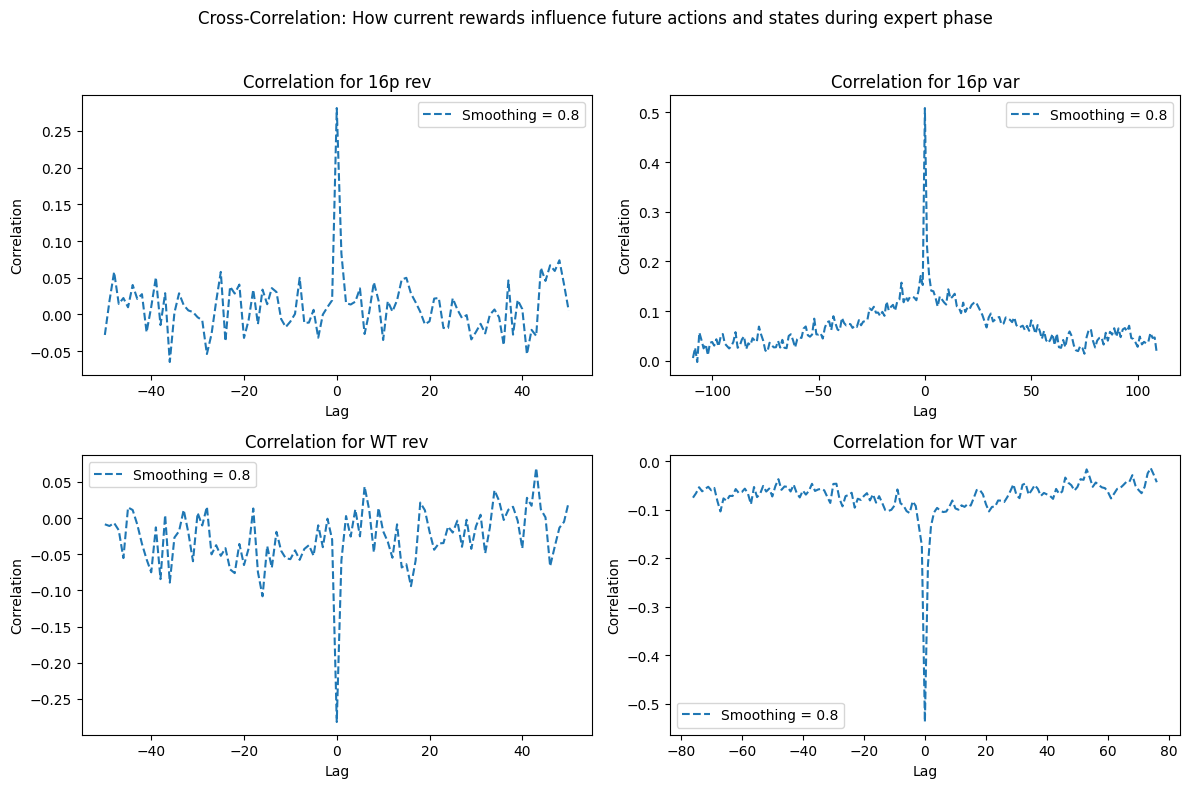

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import correlate

# Load the Excel file
df = pd.read_excel('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/Mouse_DATA.xlsx')
mouse_per_mouse_type = int(input('How many mouse/mouse_type would you like choose numbers ranging from 1 to 5?'))
# Ensure column names are correct
links_16p_rev = df['link_16p_rev'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_16p_var = df['link_16p_var'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_WT_rev = df['link_WT_rev'].iloc[:mouse_per_mouse_type].dropna().tolist()
links_WT_var = df['link_WT_var'].iloc[:mouse_per_mouse_type].dropna().tolist()

def find_expert_segments(expert_series, choice):
    expert_segments = []
    in_segment = False
    segment_start = None
    
    for i, value in enumerate(expert_series):
        if value and not in_segment:
            in_segment = True
            segment_start = i
        elif not value and in_segment:
            in_segment = False
            expert_segments.append([segment_start, i - 1])
            segment_start = None

    if in_segment:
        expert_segments.append([segment_start, len(expert_series) - 1])
    
    if choice == 1 and expert_segments:
        expert_segments = [expert_segments[0]]
    
    return expert_segments

def max_lag_per_mouseType(links, choice):
    dic = {}
    for link in links:
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        expert_series = df['expert'].reset_index(drop=True)
        expert_segments = find_expert_segments(expert_series, choice)
        dic[link] = expert_segments
    return dic

choice = int(input("Enter 1 to extract only one expert phase, or 2 to allow multiple expert phases: ").strip())

Expert_16p_rev = max_lag_per_mouseType(links_16p_rev, choice)
Expert_16p_var = max_lag_per_mouseType(links_16p_var, choice)
Expert_WT_rev = max_lag_per_mouseType(links_WT_rev, choice)
Expert_WT_var = max_lag_per_mouseType(links_WT_var, choice)

def SAR_Generator(mouse_type_links, choice):
    Expert_mouse_type = max_lag_per_mouseType(mouse_type_links, choice)
    sar_dict = {link: {'states': [], 'actions': [], 'rewards': []} for link in mouse_type_links}

    for link in mouse_type_links:
        start_link, end_link = Expert_mouse_type[link][0]
        df = pd.read_csv('/Users/saadabdisalam/Documents/MouseData_and_Analysis2024-2025/' + link)
        
        S = df['tone_freq'].iloc[start_link:end_link+1].replace({6000: '6kHz', 10000: '10kHz'}).reset_index(drop=True)
        A = df['response'].iloc[start_link:end_link+1].reset_index(drop=True)
        R = df['rew_t'].iloc[start_link:end_link+1].reset_index(drop=True)
        
        sar_dict[link]['states'].extend(S)
        sar_dict[link]['actions'].extend(A)
        sar_dict[link]['rewards'].extend(R)

    return sar_dict

def cross_correlation_manual(x, y, lag_var, mx_lag):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    c_lag = []
    
    for lag in range(-mx_lag, mx_lag + 1):
        c = 0
        if lag_var == 'x':
            if lag < 0:
                segment_x = x[:len(x) + lag]
                segment_y = y[-lag:]
            else:
                segment_x = x[lag:]
                segment_y = y[:len(x) - lag]
        else:
            if lag < 0:
                segment_x = x[-lag:]
                segment_y = y[:len(x) + lag]
            else:
                segment_x = x[:len(x) - lag]
                segment_y = y[lag:]
        
        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        
        if std_x != 0 and std_y != 0:
            for t in range(len(segment_x)):
                c += (segment_x[t] - mean_x) * (segment_y[t] - mean_y)
            c_lag.append(c / (std_x * std_y * (len(segment_x)-abs(lag))))
        else:
            c_lag.append(0)
    
    return c_lag

def AR_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_AR = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        rewards = dic_mouse_type[link]['rewards']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L' and rewards[i] == 1:
                Y_i = 2
            elif actions[i] == 'L' and rewards[i] == 0:
                Y_i = 1
            elif actions[i] == 'R' and rewards[i] == 0:
                Y_i = -1
            elif actions[i] == 'R' and rewards[i] == 1:
                Y_i = -2
            elif actions[i] == 'N':
                Y_i = 0
            Y.append(Y_i)
        DIC_AR[link].extend(Y)
    return DIC_AR

def S_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_S = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        X = []
        for i in range(len(states)):
            if states[i] == '6kHz':
                X_i = 1
            elif states[i] == '10kHz':
                X_i = -1
            X.append(X_i)
        DIC_S[link].extend(X)
    return DIC_S

def SA_mapping(mouse_type_links, choice):   
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_SA = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        states = dic_mouse_type[link]['states']
        actions = dic_mouse_type[link]['actions']
        X = []
        for i in range(len(states)):
            if (states[i] == '6kHz' and actions[i] == 'L') or (states[i] == '10kHz' and actions[i] == 'R'):
                X_i = 1
            elif (states[i] == '6kHz' and actions[i] == 'R') or (states[i] == '10kHz' and actions[i] == 'L'):
                X_i = -1
            else:
                X_i = 0
            X.append(X_i)
        DIC_SA[link].extend(X)
    return DIC_SA

def A_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_A = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        actions = dic_mouse_type[link]['actions']
        Y = []
        for i in range(len(actions)):
            if actions[i] == 'L':
                Y_i = 1
            elif actions[i] == 'R':
                Y_i = -1
            else:
                Y_i = 0
            Y.append(Y_i)
        DIC_A[link].extend(Y)
    return DIC_A

def R_mapping(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    DIC_R = {link: [] for link in mouse_type_links}
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        X = []
        for i in range(len(rewards)):
            if rewards[i] == 1:
                X_i = 1
            else:
                X_i = 0
            X.append(X_i)
        DIC_R[link].extend(X)
    return DIC_R

def min_expert_length(mouse_type_links, choice):
    dic_mouse_type = SAR_Generator(mouse_type_links, choice)
    lengths = []
    for link in mouse_type_links:
        rewards = dic_mouse_type[link]['rewards']
        lengths.append(len(rewards))
    max_lag = int(0.2 * min(lengths))
    return max_lag

def avg_correlate(mouse_type_links, choice):
    #correlator : A(t+tau)R(t)
    max_lag = min_expert_length(mouse_type_links, choice)
    total_corr = np.array(np.zeros(2*max_lag+1))
    num_links = len(mouse_type_links)
    #lag_var = input('What do you want your lag variable to be (R_seq/SA_seq)? '
    corrs=[]
    for link in mouse_type_links:
        DIC_R = R_mapping(mouse_type_links, choice)
        DIC_SA = SA_mapping(mouse_type_links, choice)
        R_seq = DIC_R[link]
        SA_seq= DIC_SA[link]
        
        cross_corr = cross_correlation_manual(R_seq, SA_seq, SA_seq, max_lag)
        total_corr += cross_corr
    lags = list(range(-max_lag, max_lag + 1))
    return total_corr / num_links, lags

def exponential_smoothing(series, alpha):
    return series.ewm(alpha=alpha).mean()

# Plotting
y_16p_rev, x_16p_rev = avg_correlate(links_16p_rev, choice)
y_16p_var, x_16p_var = avg_correlate(links_16p_var, choice)
y_WT_rev, x_WT_rev = avg_correlate(links_WT_rev, choice)
y_WT_var, x_WT_var = avg_correlate(links_WT_var, choice)

# Apply exponential smoothing
alpha = float(input('What smoothing value would you like?'))  # Smoothing factor, can be adjusted
y_16p_rev_smoothed = exponential_smoothing(pd.Series(y_16p_rev), alpha).values
y_16p_var_smoothed = exponential_smoothing(pd.Series(y_16p_var), alpha).values
y_WT_rev_smoothed = exponential_smoothing(pd.Series(y_WT_rev), alpha).values
y_WT_var_smoothed = exponential_smoothing(pd.Series(y_WT_var), alpha).values


# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
#plt.plot(x_16p_rev, y_16p_rev, label='Original')
plt.plot(x_16p_rev, y_16p_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 2)
#plt.plot(x_16p_var, y_16p_var, label='Original')
plt.plot(x_16p_var, y_16p_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for 16p var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 3)
#plt.plot(x_WT_rev, y_WT_rev, label='Original')
plt.plot(x_WT_rev, y_WT_rev_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT rev')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

plt.subplot(2, 2, 4)
#plt.plot(x_WT_var, y_WT_var, label='Original')
plt.plot(x_WT_var, y_WT_var_smoothed, label=f'Smoothing = {alpha}', linestyle='--')
plt.title('Correlation for WT var')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.legend()

# Add a single title for all plots
plt.suptitle('Cross-Correlation: How current rewards influence future actions and states during expert phase')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




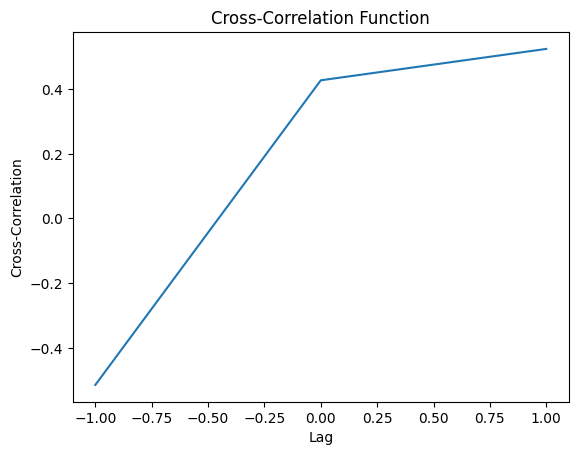

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def cross_correlation_manual(x, y):
    max_lag = int(0.2 * len(x))
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    lag_var = input('What do you want your lag variable to be (x/y)? ')
    
    c_lag = []
    
    for lag in range(-max_lag, max_lag + 1):
        c = 0
        if lag_var == 'x':
            if lag < 0:
                segment_x = x[:len(x) + lag]
                segment_y = y[-lag:]
            else:
                segment_x = x[lag:]
                segment_y = y[:len(x) - lag]
        else:
            if lag < 0:
                segment_x = x[-lag:]
                segment_y = y[:len(x) + lag]
            else:
                segment_x = x[:len(x) - lag]
                segment_y = y[lag:]
        
        std_x = np.std(segment_x)
        std_y = np.std(segment_y)
        
        if std_x != 0 and std_y != 0:
            for t in range(len(segment_x)):
                c += (segment_x[t] - mean_x) * (segment_y[t] - mean_y)
            c_lag.append(c / (std_x * std_y * (len(segment_x)-abs(lag))))
        else:
            c_lag.append(0)
    
    return c_lag

# Example usage
x = np.array([1, 2, 3, 4, 5])
y = np.array([-5, 4, -3, 2, 1])
max_lag = int(0.2 * len(x))
l = list(range(-max_lag, max_lag + 1))
cross_corr = cross_correlation_manual(x, y)
plt.plot(l, cross_corr)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation Function')
plt.show()


In [40]:
r = list(range(5))

print(r)

[0, 1, 2, 3, 4]
